In [32]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [33]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [34]:
import torch
import torch.nn.functional as F
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.autograd import Variable

In [35]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [36]:
eval_size = 0.2
num_workers = 0
batch_size = 20

In [37]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

train_data = datasets.CIFAR10(root= "data", download = True, train = True, transform = transform)
test_data = datasets.CIFAR10(root= "data", download = True, train = False, transform = transform)

Files already downloaded and verified
Files already downloaded and verified


In [38]:
num_train = len(train_data)
print("Total number of images available in CIFAR10 datasets: {}".format(num_train))

Total number of images available in CIFAR10 datasets: 50000


In [39]:
indices = list(range(num_train))
indices[:5]

[0, 1, 2, 3, 4]

In [40]:
np.random.shuffle(indices)
indices[:5]

[9392, 30917, 43441, 14944, 17859]

In [41]:
split = int(np.floor(num_train * eval_size))
train_idx, eval_idx = indices[:split], indices[split:]
train_idx[:5]
eval_idx[:5]

[9392, 30917, 43441, 14944, 17859]

[17885, 22150, 42998, 41104, 16992]

In [42]:
from torch.utils.data.sampler import SubsetRandomSampler

In [43]:
train_sampler = SubsetRandomSampler(train_idx)
eval_sampler = SubsetRandomSampler(eval_idx)

In [44]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size,
                                           sampler = train_sampler, num_workers = num_workers)
eval_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size,
                                          sampler = eval_sampler, num_workers = num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size,
                                          shuffle = False, num_workers = num_workers)

In [45]:
# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [46]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

In [47]:
type(images)
len(images)

torch.Tensor

20

In [48]:
classes[labels[0].item()]
images[0]

'airplane'

tensor([[[ 0.1294,  0.1216,  0.0980,  ..., -0.0902, -0.0980, -0.0980],
         [ 0.1608,  0.1373,  0.1216,  ..., -0.0902, -0.1059, -0.1059],
         [ 0.2078,  0.1843,  0.1686,  ..., -0.0824, -0.0902, -0.0980],
         ...,
         [ 0.0588,  0.0510,  0.0588,  ..., -0.0275, -0.0275, -0.0196],
         [ 0.0667,  0.0588,  0.0667,  ..., -0.0353, -0.0353, -0.0275],
         [ 0.0824,  0.0824,  0.0980,  ..., -0.0275, -0.0353, -0.0275]],

        [[ 0.3882,  0.3725,  0.3569,  ...,  0.2392,  0.2314,  0.2314],
         [ 0.4039,  0.3804,  0.3725,  ...,  0.2314,  0.2235,  0.2235],
         [ 0.4275,  0.4118,  0.4039,  ...,  0.2471,  0.2392,  0.2314],
         ...,
         [ 0.3412,  0.3255,  0.3412,  ...,  0.2784,  0.2784,  0.2863],
         [ 0.3412,  0.3333,  0.3490,  ...,  0.2706,  0.2627,  0.2784],
         [ 0.3569,  0.3569,  0.3725,  ...,  0.2784,  0.2706,  0.2863]],

        [[ 0.7725,  0.7569,  0.7490,  ...,  0.6863,  0.6863,  0.6863],
         [ 0.7804,  0.7569,  0.7412,  ...,  0

In [49]:
# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

In [50]:
InteractiveShell.ast_node_interactivity = 'none'

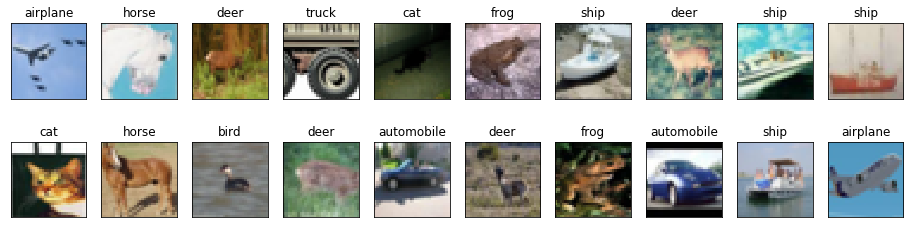

In [51]:
plt.figure(figsize = (16, 4))
for idx in range(len(images)):
    ax = plt.subplot(2, 10, idx+1, xticks = [], yticks = [])
    imshow(images[idx])
    ax.set_title(classes[labels[idx].item()])

In [52]:
InteractiveShell.ast_node_interactivity = 'all'

In [53]:
display_image = np.squeeze(images[4])
display_image.shape
display_image

torch.Size([3, 32, 32])

tensor([[[ 0.2000,  0.0667, -0.0431,  ..., -0.9608, -0.9765, -0.9843],
         [ 0.0588, -0.0745, -0.1686,  ..., -0.9765, -0.9843, -0.9922],
         [-0.0824, -0.1451, -0.2157,  ..., -0.9765, -0.9843, -0.9922],
         ...,
         [-0.4902, -0.3882, -0.3333,  ..., -0.5451, -0.5137, -0.4745],
         [-0.4196, -0.3882, -0.3725,  ..., -0.5294, -0.5608, -0.5373],
         [-0.4039, -0.4039, -0.4039,  ..., -0.4118, -0.6157, -0.6392]],

        [[ 0.2157,  0.0980,  0.0118,  ..., -0.9529, -0.9765, -0.9843],
         [ 0.0980, -0.0353, -0.1216,  ..., -0.9765, -0.9843, -0.9922],
         [-0.0353, -0.0980, -0.1686,  ..., -0.9765, -0.9843, -0.9922],
         ...,
         [-0.4196, -0.3647, -0.3412,  ..., -0.3647, -0.3569, -0.3333],
         [-0.3569, -0.3569, -0.3490,  ..., -0.3412, -0.3569, -0.4275],
         [-0.3333, -0.3412, -0.3333,  ..., -0.3725, -0.4275, -0.4667]],

        [[-0.0510, -0.1294, -0.2471,  ..., -0.9608, -0.9765, -0.9843],
         [-0.1608, -0.2392, -0.3412,  ..., -0

In [54]:
InteractiveShell.ast_node_interactivity = 'none'

In [55]:
display_image = torch.Tensor.numpy(display_image)

In [56]:
InteractiveShell.ast_node_interactivity = 'all'

In [57]:
display_image.shape
type(display_image)

(3, 32, 32)

numpy.ndarray

In [58]:
InteractiveShell.ast_node_interactivity = 'none'

In [59]:
channels = ["Red Channel", "Green Channel", "Blue Channel"]

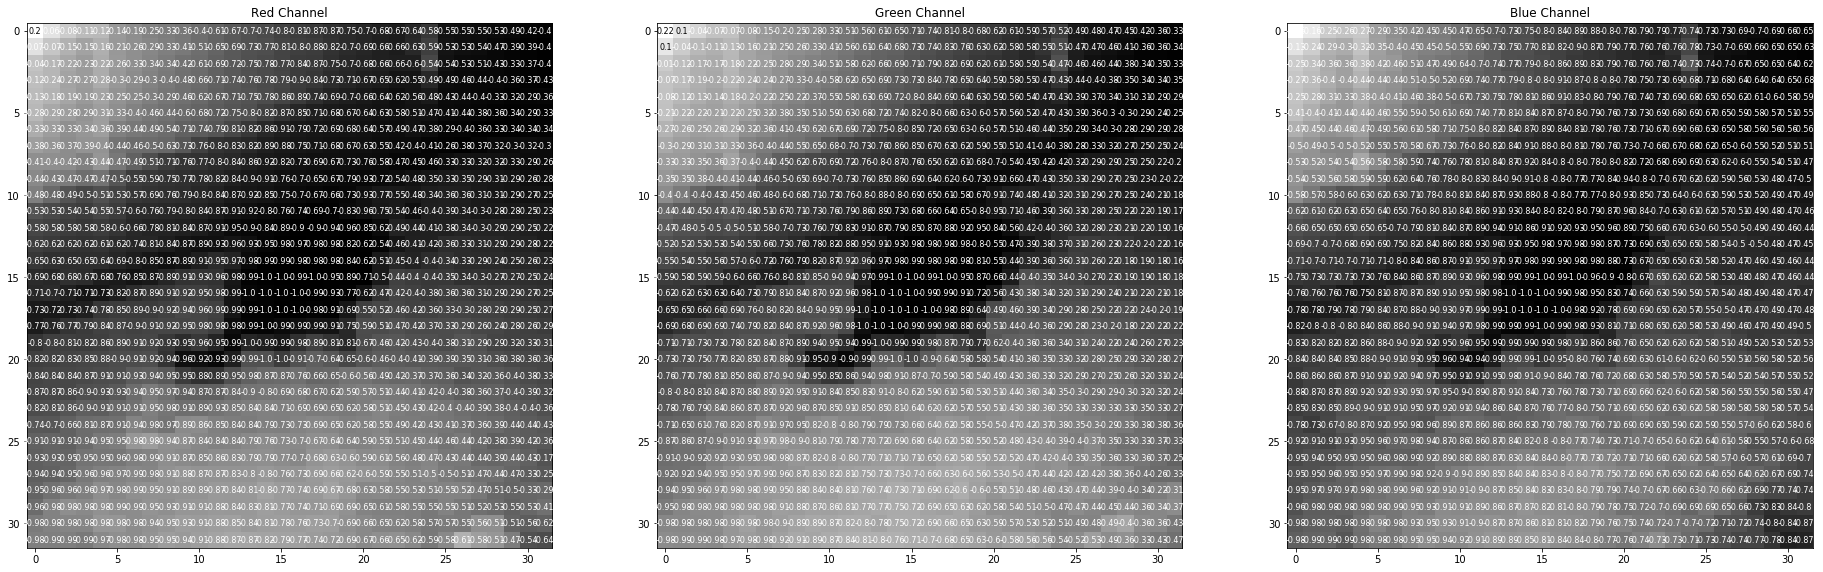

In [75]:
display_image_fig = plt.figure(figsize = (32, 32))
for id_image in range(display_image.shape[0]):
    display_image_ax = display_image_fig.add_subplot(1, 3, id_image + 1)
    img = display_image[id_image]
    
    thresh = img.max()/2.5
    
    display_image_ax.imshow(img, cmap = 'gray')
    display_image_ax.set_title(channels[id_image])
    
    width, height = img.shape
    for idx in range(width):
        for idy in range(height):
            val = round(img[idx][idy], 2) if img[idx][idy] != 0 else 0
            display_image_ax.annotate(str(val), xy = (idx, idy),
                                      horizontalalignment = 'center',
                                      verticalalignment = 'center',
                                      size = 8,
                                      color = 'white' if val < thresh else 'black'
                                     )

In [61]:
class Cifar10CNN(nn.Module):
    
    def __init__(self):
        super(Cifar10CNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 3,
                              stride = 1, padding = 1, bias = True)
        
        self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 5,
                              stride = 1, padding = 2, bias = True)

        self.conv3 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 5,
                              stride = 1, padding = 2, bias = True)
        
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)

        self.hidden1 = nn.Linear(in_features = 64 * 4 * 4, out_features = 512, bias = True)

        self.hidden2 = nn.Linear(in_features = 512, out_features = 128, bias = True)

        self.output = nn.Linear(in_features = 128, out_features = 10, bias = True)
        
        self.relu = nn.ReLU()
        
        self.dropout = nn.Dropout(p = 0.20)

    def forward(self, x):
        
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        
        x = x.view(-1, 64 * 4 * 4)
        
        x = self.dropout(x)
        x = self.relu(self.hidden1(x))
        
        x = self.dropout(x)
        x = self.relu(self.hidden2(x))
        
        x = self.dropout(x)
        x = self.output(x)
        
        return x        

In [62]:
InteractiveShell.ast_node_interactivity = 'all'

In [63]:
model = Cifar10CNN()
model.to(device)

Cifar10CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (hidden1): Linear(in_features=1024, out_features=512, bias=True)
  (hidden2): Linear(in_features=512, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2)
)

In [64]:
criterion = nn.CrossEntropyLoss()
criterion

CrossEntropyLoss()

In [65]:
optimizer = optim.SGD(model.parameters(), lr = 0.01)
optimizer

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [66]:
InteractiveShell.ast_node_interactivity = 'none'

In [67]:
epochs = 30
eval_min_loss = np.Inf

In [68]:
for epoch in range(epochs):
    
    training_loss = 0.0
    eval_loss = 0.0
    model.train()
    for images, labels in train_loader:
        
        optimizer.zero_grad()
        
        images, labels = images.to(device), labels.to(device)
        
        output_predicted = model(images)
        loss = criterion(output_predicted, labels)
        loss.backward()
        optimizer.step()
        
        training_loss += loss.item()*labels.size(0)
    else: 
        model.eval()
        with torch.no_grad():

            for eval_images, eval_labels in eval_loader:

                eval_images, eval_labels = eval_images.to(device), eval_labels.to(device)

                output_score = model(eval_images)
                loss = criterion(output_score, eval_labels)

                eval_loss += loss.item() * eval_labels.size(0)
            else:
                avg_train_loss = training_loss/len(train_loader)
                avg_eval_loss = eval_loss/len(eval_loader)
                
                print("Epoch {} : Training Loss: {} | Evaluation loss: {}"
                      .format(epoch, avg_train_loss, avg_eval_loss)
                     )

                if avg_eval_loss < eval_min_loss:
                    
                    print("Validation loss decreased from {:.6f} --> {:.6f}".format(eval_min_loss, avg_eval_loss))
                    
                    eval_min_loss = avg_eval_loss

                    torch.save(model.state_dict(), 'cnn_cifar10.pt')

Epoch 0 : Training Loss: 46.04955951690674 | Evaluation loss: 46.03863483428955
Validation loss decreased from inf --> 46.038635
Epoch 1 : Training Loss: 45.99855055809021 | Evaluation loss: 45.976458368301394
Validation loss decreased from 46.038635 --> 45.976458
Epoch 2 : Training Loss: 45.9020627117157 | Evaluation loss: 45.77931357383728
Validation loss decreased from 45.976458 --> 45.779314
Epoch 3 : Training Loss: 45.114370307922364 | Evaluation loss: 43.2531980919838
Validation loss decreased from 45.779314 --> 43.253198
Epoch 4 : Training Loss: 41.67296123504639 | Evaluation loss: 39.57789123892784
Validation loss decreased from 43.253198 --> 39.577891
Epoch 5 : Training Loss: 38.760800008773806 | Evaluation loss: 36.961993184089664
Validation loss decreased from 39.577891 --> 36.961993
Epoch 6 : Training Loss: 36.58798902988434 | Evaluation loss: 34.65483873963356
Validation loss decreased from 36.961993 --> 34.654839
Epoch 7 : Training Loss: 34.83212365150452 | Evaluation los

In [69]:
with torch.no_grad():
    
    test_loss = 0.0
    
    dataiter = iter(test_loader)
    test_image, test_labels = next(dataiter)
    print(test_labels)
    
    test_image, test_labels = test_image.to(device), test_labels.to(device)

    output = model(test_image)
    pred_pb, pred_class = torch.max(output, 1)
    print(pred_class)
    
    equals = pred_class == test_labels

    accuracy = torch.mean(equals.type(torch.FloatTensor))
    
    test_image, test_labels, pred_class = test_image.to('cpu'), test_labels.to('cpu'), pred_class.to('cpu')

tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6])
tensor([3, 8, 8, 8, 6, 6, 1, 4, 5, 1, 0, 9, 3, 7, 9, 8, 5, 9, 8, 6],
       device='cuda:0')


In [70]:
InteractiveShell.ast_node_interactivity = 'all'

In [71]:
rows = 2
cols = len(test_image)
cols

20

In [72]:
InteractiveShell.ast_node_interactivity = 'none'

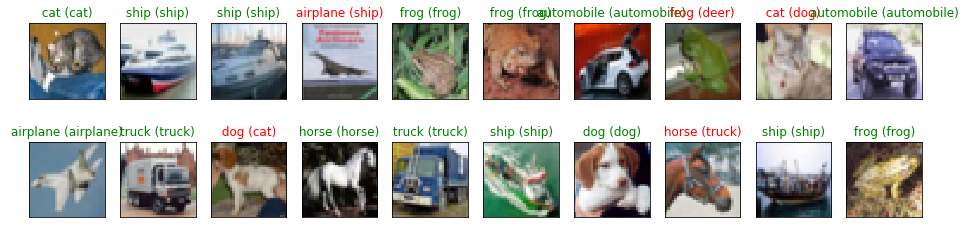

In [73]:
fig = plt.figure(figsize = (16, 4))

for idx in range(cols):
    
    ax = fig.add_subplot(rows, cols / rows, idx + 1, xticks = [], yticks = [] )
    imshow(test_image[idx].to('cpu'))
    ax.set_title(' {} ({}) '.format(classes[test_labels[idx]],
                                   classes[pred_class[idx]]
                                   ),
                 color = ( 'green' if test_labels[idx] == pred_class[idx] else 'red')
                )